<a href="https://colab.research.google.com/github/FleaBusyBeeBergs/dtsa5511-rnn/blob/main/nlp_disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 4: Natural Disaster Tweets - RNN model

## DTSA 5511 - Intro to Deep Learning

The purpose of this project is to classify tweets as either a true natural disaster or not true natural disaster using a Recurrent Neural Network (RNN). RNNs are useful for sequential datasets, such as natural language processing. In natural language, the order in which words appear may change the meaning of the sentence. RNNs take this sequence into consideration by making a backwards pass over the data to update the model weights.

In [32]:
# !pip install imbalanced-learn

In [28]:
# general utilities
import os
import pandas as pd
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
import re
import nltk

from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
#import string
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# get set up with kaggle
files.upload()
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# note to self: '_kaggle' file is in dtsa5511 folder

Saving kaggle.json to kaggle.json


In [5]:
!kaggle competitions download -c nlp-getting-started -p /content/data > /dev/null
!unzip /content/data/nlp-getting-started -d ./data > /dev/null

100% 593k/593k [00:00<00:00, 955MB/s]


In [6]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

## EDA & Cleaning

In [7]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


The training dataset contains a little over 7,600 tweets, all with labels. The columns included are:
Numerical - id and target (bool)
Text objects - keyword, location, and text.

In [9]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
na = df_train[df_train['keyword'].notna()]
na

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0


In [11]:
df_train.loc[0:31,]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


target
0    0.57034
1    0.42966
Name: count, dtype: float64 



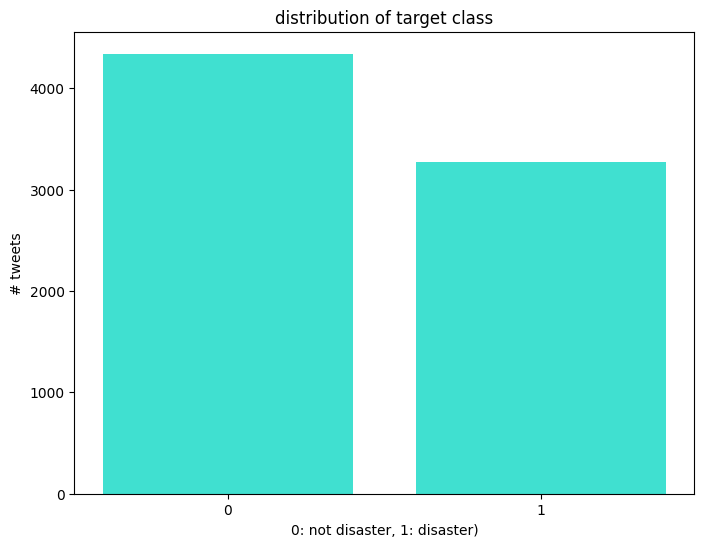

In [12]:
category_counts = df_train['target'].value_counts()
category_prop = category_counts / category_counts.sum()
print(category_prop, '\n')

# vis distribution
plt.figure(figsize = (8, 6))
plt.bar(category_counts.index,
        category_counts.values,
        color = 'turquoise')
plt.xticks([0, 1])
plt.title('distribution of target class')
plt.xlabel('0: not disaster, 1: disaster)')
plt.ylabel('# tweets')
plt.show()

In [13]:
# check for missing data
total = df_train.isnull() \
                .sum() \
                .sort_values(ascending = False)

# percent missing
percent = df_train.isnull() \
                  .sum()/df_train.isnull().count() \
                  .sort_values(ascending = False)

nulls = pd.concat([total, percent],
                  axis = 1,
                  keys = ['Total', 'Percent'])

nulls.head(df_train.shape[1])

,Total,Percent
location,2533,0.332720
keyword,61,0.008013
id,0,0.000000
text,0,0.000000
target,0,0.000000


In [14]:
# add keyword into text column
df_train['keyword'] = df_train['keyword'].fillna('')
df_train['combined_text'] = df_train['keyword'] + ' ' + df_train['text']

In [15]:
df_train.head()

,id,keyword,location,text,target,combined_text
0,1,,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake ...
1,4,,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are...
3,6,,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation o..."
4,7,,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as...


In [16]:
df_train = df_train.drop(columns = 'text')

In [17]:
df_train.rename(columns = {'combined_text': 'text'}, inplace = True)

In [18]:
df_train.head()

,id,keyword,location,target,text
0,1,,NaN,1,Our Deeds are the Reason of this #earthquake ...
1,4,,NaN,1,Forest fire near La Ronge Sask. Canada
2,5,,NaN,1,All residents asked to 'shelter in place' are...
3,6,,NaN,1,"13,000 people receive #wildfires evacuation o..."
4,7,,NaN,1,Just got sent this photo from Ruby #Alaska as...


In [19]:
df_train['keyword'].unique()


array(['', 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'dera

In [22]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-z\s]", "", text)  # Keep only alphabets
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

In [21]:
def preprocess_tweet(text):
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return " ".join(words)

In [23]:
def load_glove_embeddings(glove_path="glove.6B.100d.txt"):
    embeddings_index = {}
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = vector
    return embeddings_index

In [24]:
def get_embedding_matrix(tokenizer, embedding_dim=100, glove_path="glove.6B.100d.txt"):
    embeddings_index = load_glove_embeddings(glove_path)
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  # Use GloVe embedding
    return embedding_matrix

In [25]:
# train test split - 80% train, 20% validation
X = df_train['text']
y = df_train['target']

X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size = 0.20,
                                                  random_state = 5511,
                                                  stratify = y)

In [ ]:
# preprocess
X_train = X_train.apply(clean_text)

## Model Architecture

In [33]:
# apply SMOTE to trg data for imbalance
smote = SMOTE(random_state = 5011)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print('shape of original trg data:', X_train.shape)
print('shape of resmple trg data:', X_train_resampled.shape)
print('smote class dist:')
Print(y_train_resampled.value_counts())

ValueError: could not convert string to float: "drowning I feel like I'm drowning inside my own body!!"

In [29]:
# model1
model1 = tf.keras.Sequential([tf.keras.layers.Embedding(input_dim = 10000,
                                                       output_dim = 128),
                             tf.keras.layers.LSTM(64),
                             tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [30]:
# model1 compile
model1.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [31]:
# model1 fit
clear_session()

early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 3)

history = model1.fit(X_train_resampled,
                     y_train_resampled,
                     epochs = 10,
                     validation_data = (X_val, y_val),
                     verbose = 0,
                     callbacks  = [early_stopping])

NameError: name 'X_train_resampled' is not defined

In [ ]:
history1 = pd.DataFrame(history.history)
history1.head()

,accuracy,loss,val_accuracy,val_loss
0,0.506959,0.692968,0.586343,0.684637
1,0.496811,0.693433,0.586343,0.693124
2,0.491882,0.693454,0.586343,0.690852
3,0.502899,0.693213,0.413657,0.694077


In [ ]:
model2 = tf.keras.Sequential([tf.keras.layers.Embedding(input_dim = 10000,
                                                        output_dim = 128),
                              tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                              tf.keras.layers.Dense(1, activation = 'sigmoid')])

In [ ]:
model2.compile(optimizer = 'adam',
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])

In [ ]:
# model2 fit
clear_session()

early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 3)


history = model2.fit(X_train_resampled,
                     y_train_resampled,
                     epochs = 10,
                     validation_data = (X_val, y_val),
                     verbose = 0,
                     callbacks  = [early_stopping])

In [ ]:
history2 = pd.DataFrame(history2)
history2

,accuracy,loss,val_accuracy,val_loss
0,0.566338,0.685676,0.586343,0.684825
1,0.566338,0.684728,0.586343,0.679670
2,0.566338,0.685265,0.586343,0.679921
3,0.566338,0.684782,0.586343,0.681429
4,0.566338,0.684733,0.586343,0.679581
5,0.566338,0.684851,0.586343,0.678619
6,0.566338,0.684541,0.586343,0.681187
7,0.566338,0.684691,0.586343,0.678579
8,0.566338,0.684950,0.586343,0.681141
9,0.566338,0.684789,0.586343,0.678665


class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout_rate=0.5):
        super(LSTMModel, self).__init__()

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # x is of shape (batch_size, seq_len, input_size)

        # LSTM layer
        lstm_out, (hn, cn) = self.lstm(x)

        # Use the output of the last LSTM time step (last hidden state)
        lstm_out = lstm_out[:, -1, :]  # Shape: (batch_size, hidden_dim)

        # Pass through dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        return out

### Model hyperparameters section
hyperparameters = {
    'input_dim': X_train_combined.shape[1],  # Number of features (after TF-IDF + normalized features)
    'hidden_dim': 64,                       # Number of features in the hidden state
    'output_dim': 2,                        # Number of classes (adjust based on your problem)
    'num_layers': 2,                        # Number of LSTM layers
    'dropout_rate': 0.5,                    # Dropout rate for regularization
    'learning_rate': 0.001                  # Learning rate for optimizer
}

### Instantiate the model using the hyperparameters
model = LSTMModel(
    input_dim=hyperparameters['input_dim'],
    hidden_dim=hyperparameters['hidden_dim'],
    output_dim=hyperparameters['output_dim'],
    num_layers=hyperparameters['num_layers'],
    dropout_rate=hyperparameters['dropout_rate']
)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'])

## Results and Analysis


## Conclusion

## References
